<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#вывод" data-toc-modified-id="вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>вывод</a></span></li></ul></div>

# Проект "Прогнозирование количества заказов такси"

# Описание проекта

Кампании такси для привлечения водителей в периоды нагрузки в аэропортах, необходимо прогнозировать количество заказов на ближайший час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Данные предоставлены. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 

* **Цели**: 
    * Прогноз количества заказов такси на следующий час для планирования привлечения водителей в период пиковой нагрузки. 
<br>
* **Задача**: Получить модель со значением метрики RMSE, меньшей 48.
<br>
* **План работы**:
    * Загрузка данных, ресэмплирование до периода в 1 час.
    * Анализ данных, проверка на монотонность, выявление тренда и сезоностей.
    * Деление датасета на выборки: тренировочная и тестовая  в пропорции 90:10
    * Подбор параметров моделей, для минимизации RMSE
    * Анализ полученных результатов
    * Общий вывод
    


## Подготовка

In [1]:
# Импортируем модули
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import os
import time
import re
import numpy as np
import pandas.util.testing as tm

C:\Users\tito_\anaconda3\envs\praktikum_env_win_new\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Загрузка данных

In [2]:
# Загрузка данных
pth1 = 'datasets/taxi.csv'
pth2 = '/datasets/taxi.csv'
if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print("Проверьте правильность пути к датасету")
#data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# проверка, что индекс монотонный
print(data.index.is_monotonic)


True


In [4]:
# Посмтрим на данные
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
# посмотрим пропуски
data.isna().sum()

num_orders    0
dtype: int64

Пропуски отсутсвуют

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Имеем данные по количеству заказов за каждые 10 минут. Переведем все в часовой интервал, используя ресемплирование

# Ресемплирование

In [7]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Вывод

* Данные подгружены
* Пропусков не имеется
* Данные упорядочены по времени и представлены в порядке возрастания
* Произведено ресемплирвание данных с 10 минут до часа.

## Анализ

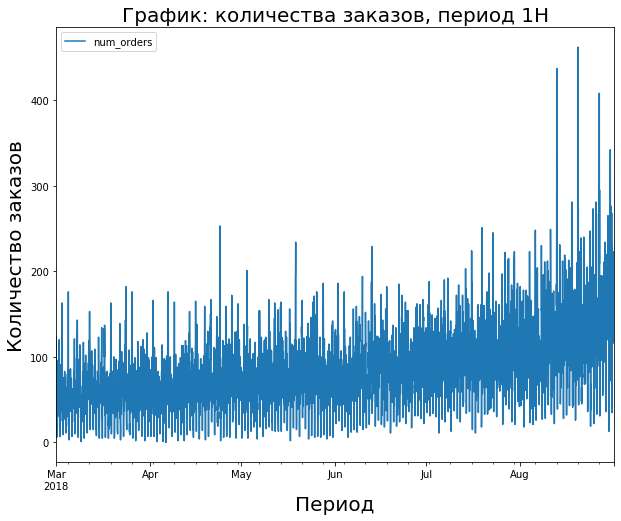

In [8]:
# Данные на графике
data.plot(figsize=(10,8))
plt.title("График: количества заказов, период 1H", fontsize=20)
plt.xlabel('Период', fontsize=20)
plt.ylabel('Количество заказов', fontsize=20)
plt.show()

In [9]:
# Имеем данные с 
print('Начало диапазона:', data.index.min())
print('Начало диапазона:', data.index.max())
print('Всего', data.index.max() - data.index.min())

Начало диапазона: 2018-03-01 00:00:00
Начало диапазона: 2018-08-31 23:00:00
Всего 183 days 23:00:00


На графике прослеживается небольшая восходящая тенденция по увеличению заказов

In [10]:
#Добавим на график скользящую среднюю
data['rolling_mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(15).std()

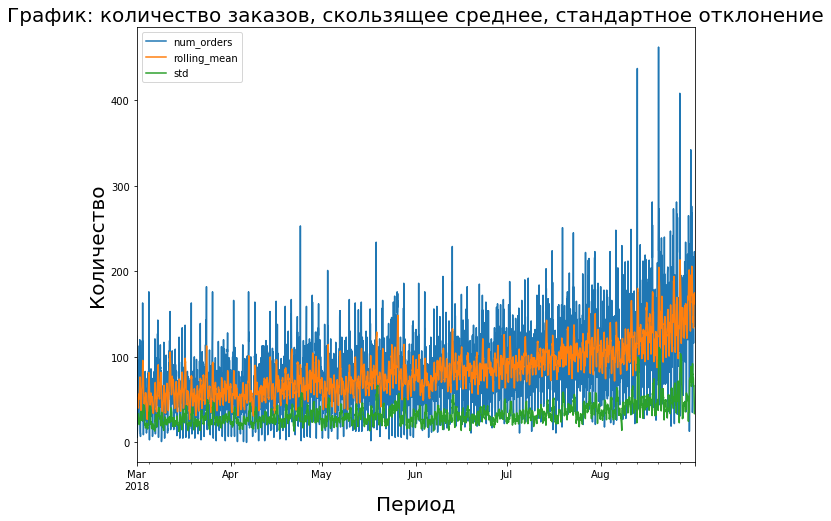

In [11]:
data.plot(figsize=(10,8))

plt.title("График: количество заказов, скользящее среднее, стандартное отклонение", fontsize=20)
plt.xlabel('Период', fontsize=20)
plt.ylabel('Количество', fontsize=20)
plt.show()

# Тренды и сезонность

In [12]:
#Посмотрим данные по дням
data_D = data.resample('1D').sum()
data_D

,num_orders,rolling_mean,std
datetime,,,
2018-03-01,1364,755.7,250.522330
2018-03-02,1506,1417.7,716.033117
2018-03-03,1290,1437.6,780.661322
2018-03-04,1141,1067.0,462.175680
2018-03-05,1259,1345.6,778.902667
...,...,...,...
2018-08-27,3936,3950.4,1866.883756
2018-08-28,3357,3338.4,967.563643
2018-08-29,3762,3597.6,1148.401839


In [13]:
# разложим наш датасет
decomposed = seasonal_decompose(data_D['num_orders'])

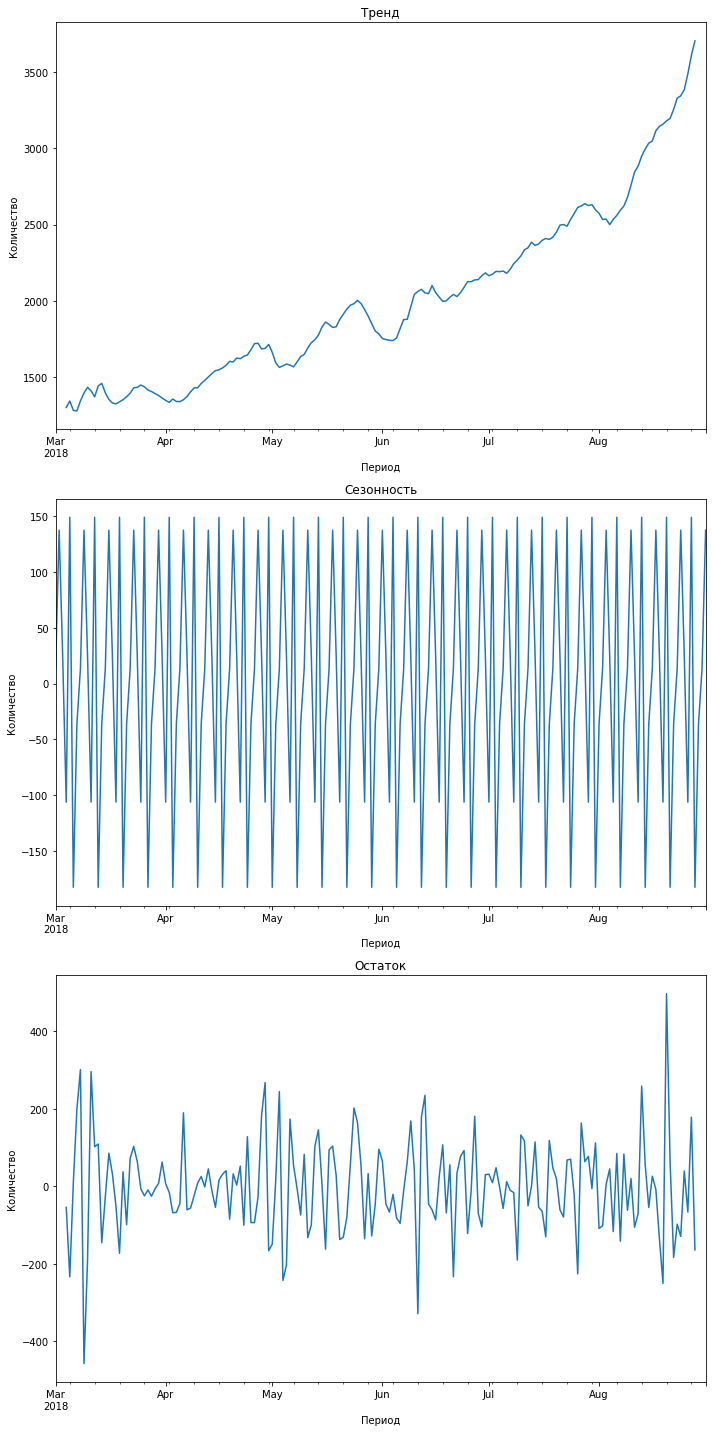

In [14]:

plt.figure(figsize=(10, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())

plt.xlabel('Период')
plt.ylabel('Количество')

plt.title('Тренд')
plt.subplot(312)
# < напишите код здесь >
decomposed.seasonal.plot(ax=plt.gca())

plt.xlabel('Период')
plt.ylabel('Количество')

plt.title('Сезонность')
plt.subplot(313)
# < напишите код здесь >
decomposed.resid.plot(ax=plt.gca())

plt.xlabel('Период')
plt.ylabel('Количество')

plt.title('Остаток')
plt.tight_layout()


plt.show()

Глядя на весь диапазон:

* виден восходящий тренд по количеству заказов.
* Сезонность имеет пилообразный горизонтальный график: на неделе есть загруженные дни с большим количеством заказов- зачастую пятница и суббота - они дают пики, и с малым количеством заказов - воскресенье

Посмотрим на данные позаказам на часовом графике

In [15]:
# переведем данные в часовой диапазон
data_H = data.resample('1H').sum()

In [16]:
# Сехонность внутри дня
decomposed_parts = seasonal_decompose(data_H['2018-08-24':'2018-08-31']['num_orders'])

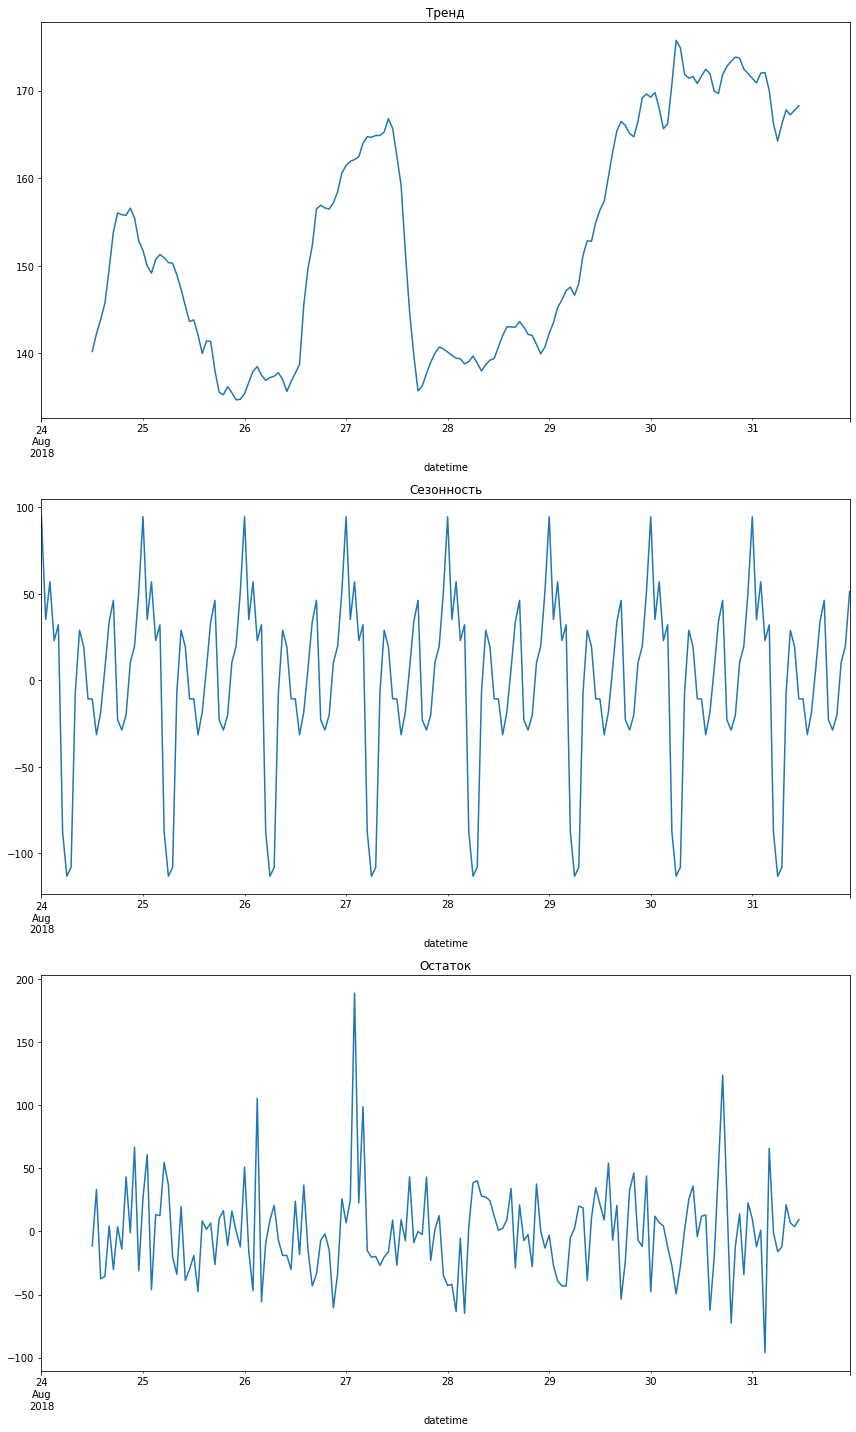

In [17]:

plt.figure(figsize=(12, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_parts.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
# < напишите код здесь >
decomposed_parts.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
# < напишите код здесь >
decomposed_parts.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()


В течение суток прослеживается сезонность, утром - спад по заказам, максимальное количество заказов приходится на вечер и до 12 ночи примерно

# Стациорарность

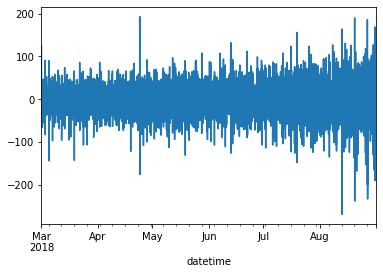

In [18]:
# Методом shift() сдвинем данные на 1 час и посчитаем разность
data_H_delta = data_H['num_orders'] - data_H['num_orders'].shift(fill_value=0)
data_H_delta.plot()

### Вывод

* Имеем данные за 183 дня. По данным о заказах видно, что есть тенденция к росту.
* Наблюдается "сезонность" внутри дня - ночью люди спят, поэтому спад заказов, пик заказов приходится на вечернее и полуночное время
* Также есть сезонность внутри недели: пятница и суббота традиционно самые большие поп заказам. В восерсенье наблюдается спад.


## Обучение

Горизонт прогнозирования количества заказов- следующий ближайший час

# Создание признаков

In [19]:
# Исправленная функция, lag1 = 1, lag2= 24
#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data_mod = data
#    data_mod['month'] = data.index.month
#    data_mod['day'] = data.index.day
    data_mod['dayofweek'] = data.index.dayofweek
    data_mod['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 25, 24):
        data_mod['lag_{}'.format(lag)] = data_mod['num_orders'].shift(lag)

    data_mod['rolling_mean'] = data_mod['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_mod
data_H = make_features(data_H, 2, 24)
data_H

,num_orders,rolling_mean,std,dayofweek,hour,lag_1,lag_25
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,0.000000,3,0,NaN,NaN
2018-03-01 01:00:00,85,NaN,0.000000,3,1,124.0,NaN
2018-03-01 02:00:00,71,NaN,0.000000,3,2,85.0,NaN
2018-03-01 03:00:00,66,NaN,0.000000,3,3,71.0,NaN
2018-03-01 04:00:00,43,NaN,0.000000,3,4,66.0,NaN
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,57.917018,4,19,207.0,177.0
2018-08-31 20:00:00,154,167.541667,54.650578,4,20,136.0,72.0
2018-08-31 21:00:00,159,168.041667,43.955605,4,21,154.0,142.0


In [20]:
# Лаги сдвинулись на час и на сутки. Скользящее среднее с периодом 24
data_H.isna().sum()

num_orders       0
rolling_mean    24
std              0
dayofweek        0
hour             0
lag_1            1
lag_25          25
dtype: int64

In [21]:
# удалим пропуски
data_H = data_H.dropna()
data_H.isna().sum()

num_orders      0
rolling_mean    0
std             0
dayofweek       0
hour            0
lag_1           0
lag_25          0
dtype: int64

In [22]:
# Делаем выборки, тренировочную и тестовую
train, test = train_test_split(data_H, shuffle=False, test_size=0.1)

In [23]:
# чтобы убедиться в корректности деления выборок, важно, чтобы данные не перемешались
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [24]:
# признаки и целевой признак
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

In [25]:
features_train.isna().sum()

rolling_mean    0
std             0
dayofweek       0
hour            0
lag_1           0
lag_25          0
dtype: int64

Данные в выборках не перемешались

# Константная модель

In [26]:
# Проверим RMSE для константной модели
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])


In [27]:
# RMSE константной модели
print("RMSE:", mean_squared_error(pred_previous, test['num_orders']) ** 0.5)

RMSE: 58.881776776551476


пользуясь константной моделью (когда предсказываемое значение находится через сдвиг) качество прогноза по метрике RMSE больше целевого 48

In [28]:
# Создадим список словарей с результатами по каждой модели

all_algo = []

In [29]:
# Функция обучения и предсказания, на вход принимает алгоритм, признаки, целевой признак и параметры
# принимает на вход название алгоритма, признаки, целевой признак и параметры для Grid
# В параметрах можно задать перебор
# возвращает словарь с данными о времени обучения и rmse
def fit_predict(algo, X_train, y_train, X_test, y_test, parametrs):


#     if algo == LinearRegression:
#         model_grid = algo()

#     else:
    model = algo()
    #Добавлено исправление
    
    # надо посмотреть, как подобрать параметр и аргументировать
    tscv = TimeSeriesSplit(n_splits=8)
    model_grid = GridSearchCV(model, n_jobs=-1, param_grid=parametrs, scoring='neg_mean_squared_error', cv=tscv)
    #Добавлено исправление
    
    start_fit = time.time()
    model_grid_best = model_grid.fit(X_train, y_train)
    print(model_grid_best.best_params_)
    stop_fit = time.time()
    start_pred_test =  time.time()
    predicted_test = model_grid_best.predict(X_test)
    stop_pred_test = time.time()
    rmse_test = mean_squared_error(y_test, predicted_test) ** 0.5

    start_pred_train =  time.time()
    predicted_train = model_grid_best.predict(X_train)
    stop_pred_train = time.time()
    rmse_train = mean_squared_error(y_train, predicted_train) ** 0.5

    time_fit = stop_fit - start_fit
    time_predict_test = stop_pred_test - start_pred_test
    time_predict_train = stop_pred_train - start_pred_train
    algo = str(algo).split(sep='.')

    algo = re.sub("[^A-Za-z0-9]",'',str(algo[-1]))
    t = {'algo' : algo,
         'time_fit': round(time_fit, 6),
         'time_predict_train': round(time_predict_train, 6),
         'time_predict_test': round(time_predict_test, 6),
         'rmse_train': round(rmse_train, 2),
         'rmse_test': round(rmse_test, 2)
        }
    return t

# LinearRegression

In [30]:
params = {'normalize': [True, False],
          'fit_intercept': [True, False],
          'copy_X': [True, False],
#           'c': [0.1, 1, 10, 100],
#           'solver': ['liblinear', 'saga']
         }
lr_result = fit_predict(LinearRegression, features_train, target_train,features_test, target_test, params)

{'copy_X': True, 'fit_intercept': False, 'normalize': True}


C:\Users\tito_\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


In [31]:
lr_result

{'algo': 'LinearRegression',
 'time_fit': 4.621995,
 'time_predict_train': 0.003006,
 'time_predict_test': 0.002002,
 'rmse_train': 30.64,
 'rmse_test': 50.19}



**DecisionTreeRegressor**

In [32]:

params = {'max_depth': range(1,10),
          'random_state': [12345]}
dtr_result = fit_predict(DecisionTreeRegressor, features_train, target_train,features_test, target_test, params)

{'max_depth': 7, 'random_state': 12345}


In [33]:
dtr_result

{'algo': 'DecisionTreeRegressor',
 'time_fit': 0.700527,
 'time_predict_train': 0.002,
 'time_predict_test': 0.002001,
 'rmse_train': 21.92,
 'rmse_test': 48.34}

# CatBoostRegressor

In [34]:

params = {'max_depth': range(5,6),
          'n_estimators': range(100, 120),
          'random_state': [12345],
          'learning_rate': np.arange(0.3, 0.9, 0.2)}
crb_result = fit_predict(CatBoostRegressor, features_train, target_train,features_test, target_test, params)


0:	learn: 34.3966412	total: 69.8ms	remaining: 6.91s
1:	learn: 30.9090973	total: 73.1ms	remaining: 3.58s
2:	learn: 29.1858508	total: 76ms	remaining: 2.46s
3:	learn: 27.8595579	total: 78.6ms	remaining: 1.89s
4:	learn: 26.8997878	total: 81.3ms	remaining: 1.54s
5:	learn: 26.1069825	total: 84.1ms	remaining: 1.32s
6:	learn: 25.4013202	total: 86.8ms	remaining: 1.15s
7:	learn: 25.0788721	total: 89.4ms	remaining: 1.03s
8:	learn: 24.9754091	total: 92ms	remaining: 931ms
9:	learn: 24.7113722	total: 94.7ms	remaining: 852ms
10:	learn: 24.3119608	total: 97.4ms	remaining: 788ms
11:	learn: 24.1604368	total: 100ms	remaining: 735ms
12:	learn: 23.8125248	total: 104ms	remaining: 693ms
13:	learn: 23.4737465	total: 106ms	remaining: 653ms
14:	learn: 23.2013312	total: 110ms	remaining: 622ms
15:	learn: 22.9795257	total: 113ms	remaining: 594ms
16:	learn: 22.9377305	total: 116ms	remaining: 566ms
17:	learn: 22.8164221	total: 119ms	remaining: 540ms
18:	learn: 22.6964421	total: 121ms	remaining: 517ms
19:	learn: 22.4

In [35]:
crb_result

{'algo': 'CatBoostRegressor',
 'time_fit': 76.022702,
 'time_predict_train': 0.003,
 'time_predict_test': 0.002998,
 'rmse_train': 17.24,
 'rmse_test': 43.07}

# LGBMRegressor

In [36]:
params = {
    'boosting_type': ['dart'],
    'objective': ['regression'],
    'force_col_wise': [True],
    'num_leaves': range(13, 15), 
    'learning_rate': np.arange(0.3, 0.5, 0.1),
    'bagging_fraction': np.arange(0.6, 0.7, 0.1),
    'verbose':[0]
}
lgbt_result = fit_predict(LGBMRegressor, features_train, target_train,features_test, target_test, params)
lgbt_result

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
{'bagging_fraction': 0.6, 'boosting_type': 'dart', 'force_col_wise': True, 'learning_rate': 0.4, 'num_leaves': 14, 'objective': 'regression', 'verbose': 0}


{'algo': 'LGBMRegressor',
 'time_fit': 2.411057,
 'time_predict_train': 0.039999,
 'time_predict_test': 0.005997,
 'rmse_train': 16.47,
 'rmse_test': 40.76}

## Тестирование

In [37]:
# соберем все результаты в один список
all_algo.append(lr_result)
all_algo.append(dtr_result)
all_algo.append(crb_result)
all_algo.append(lgbt_result)

In [38]:
# Список в пандас
# Сделаем датафрейм и посторим графики
df_all_algo = pd.DataFrame(all_algo)

df_all_algo.columns = ['Алгоритм', 'Время обучения', 'Время предсказания train','Время предсказания test' , 'rmse train', 'rmse test']
df_all_algo = df_all_algo.set_index('Алгоритм')
df_all_algo

,Время обучения,Время предсказания train,Время предсказания test,rmse train,rmse test
Алгоритм,,,,,
LinearRegression,4.621995,0.003006,0.002002,30.64,50.19
DecisionTreeRegressor,0.700527,0.002000,0.002001,21.92,48.34
CatBoostRegressor,76.022702,0.003000,0.002998,17.24,43.07
LGBMRegressor,2.411057,0.039999,0.005997,16.47,40.76


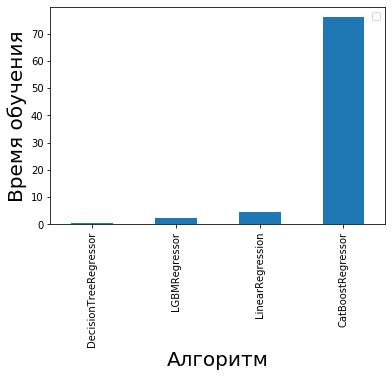

In [39]:
df_all_algo['Время обучения'].sort_values().plot(kind='bar')
plt.title("", fontsize=20)
plt.xlabel("Алгоритм", fontsize=20)
plt.ylabel("Время обучения", fontsize=20)
plt.legend('')
plt.show()

По времени обучения самые долгие  -LGBM и CatBoostRegersor. Причем LGBM обучается в разы дольше

# Время предсказания, тренировочная выборка

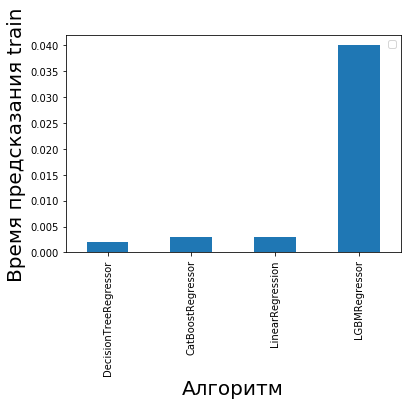

In [40]:
df_all_algo['Время предсказания train'].sort_values().plot(kind='bar')
plt.title("", fontsize=20)
plt.xlabel("Алгоритм", fontsize=20)
plt.ylabel("Время предсказания train", fontsize=20)
plt.legend('')
plt.show()

По времени предсказания лидерство также за LGBM алгоритмом, самый задумчивый

# RMSE тренировочная выборка

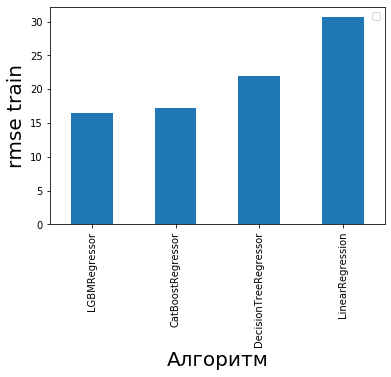

In [41]:
df_all_algo['rmse train'].sort_values().plot(kind='bar')
plt.title("", fontsize=20)
plt.xlabel("Алгоритм", fontsize=20)
plt.ylabel("rmse train", fontsize=20)
plt.legend('')
plt.show()

Лучший показатель RMSE у LGBM алгоритма, немногим хуже показал себя CatBoostRegressor

In [42]:
params = {'bagging_fraction': [0.6], 
          'boosting_type': 'dart', 
          'force_col_wise': [True], 
          'learning_rate': [0.4], 
          'num_leaves': [14], 
          'objective': ['regression'], 
          'verbose': [0]}
#model = LGBMRegressor(params)
model = LGBMRegressor(bagging_fraction=0.6, 
          boosting_type='dart', 
          force_col_wise=True, 
          learning_rate=0.4, 
          num_leaves=14, 
          objective='regression', 
          verbose=0)

model.fit(features_train,target_train)
predict_lgbt = model.predict(features_test)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


In [43]:
data_lgbt = pd.DataFrame()
data_lgbt['y'] = target_test
data_lgbt['pred_lgbt'] = predict_lgbt
data_lgbt['delta'] = data_lgbt['y'] - data_lgbt['pred_lgbt']

In [44]:
data_lgbt

,y,pred_lgbt,delta
datetime,,,
2018-08-13 16:00:00,144,151.266489,-7.266489
2018-08-13 17:00:00,152,131.607507,20.392493
2018-08-13 18:00:00,104,80.595059,23.404941
2018-08-13 19:00:00,91,89.886827,1.113173
2018-08-13 20:00:00,82,95.227654,-13.227654
...,...,...,...
2018-08-31 19:00:00,136,138.110624,-2.110624
2018-08-31 20:00:00,154,121.932499,32.067501
2018-08-31 21:00:00,159,132.242955,26.757045


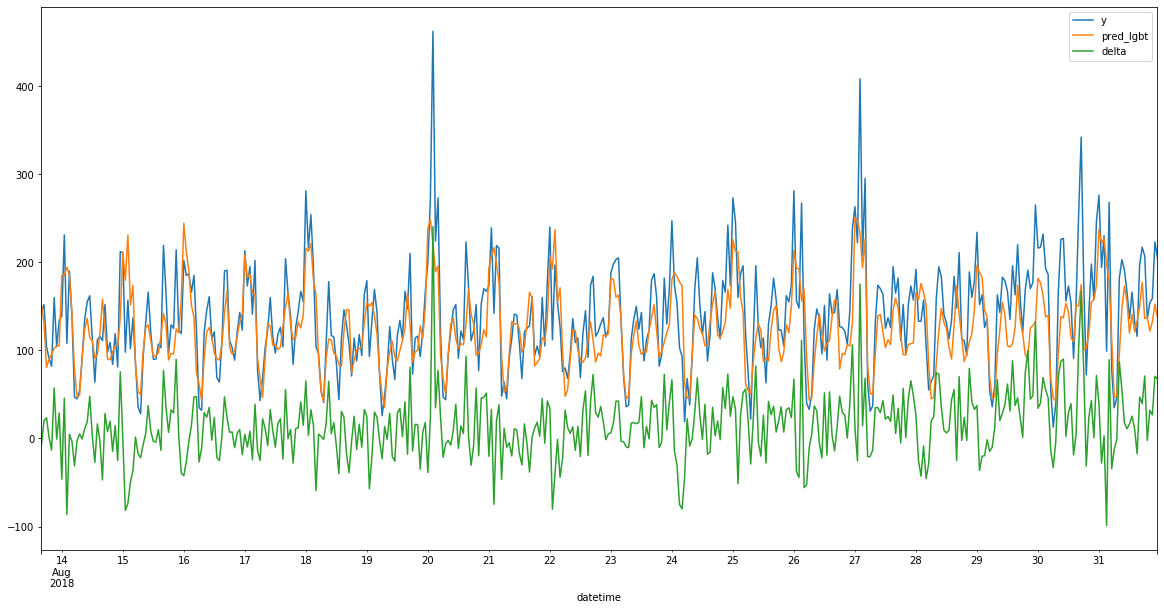

In [45]:
# Посомтрим в графическом представлении, как будут отображаться истинное значение с предсказанным и их разность
data_lgbt.plot(figsize=(20,10))

### Вывод

* По итогам работы обученных моделей можно сделать вывод:
    * Самую лучшую метрику RMSE на тренировочной выборке показал алгоритм LGBMregressor, на втором месте CatBoostregressor
    * На тестовой выборке эти два алгоритма также проявили себя хорошо, показав результаты ниже требуемого 48. RMSE у алгоритма LGBM = 42.59, у CatBoostRegressor = 44.63
    * Константная модель при этом показала RMSE = 58

## вывод

В ходе работы над проектом было сделано:

* Подгружены и проверены данные
* Произведено ресэмплирование данныех о заказах до периода в 1 час
* В ходе анализа данных определена сезонность по заказам внутри недели, и внутри дня.
* Определен восходящий тренд по количеству заказов. С течением времени заказов у кампании прибавляется.
* Проверили данные на стационарность.
* Создали дополнительные признаки путем сдвига
* Определили RMSE на константной моделе - значение 58 - это выше целевого в 48.
* Подобрали параметры для обучения 4х моделей: LinearRegressor, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor.
* Результаты RMSE свели для анализа в одну таблицу.
* Лучшие показатели по метрике RMSE у модели LGBMRegressor и равен 40.76
